#Mounting google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# import the necessary packages

In [ ]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from warnings import filterwarnings
from imutils import paths
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from skimage import io
import numpy as np
import pandas as pd
import os
import cv2
filterwarnings("ignore")

#unzip the dataset folder

In [ ]:
!unzip /content/drive/MyDrive/datasets/facemaskproject/dataset.zip

#defining the data path


In [ ]:
data_path = '/content/dataset'

# initialize the initial learning rate, number of epochs and batch size

In [ ]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

#grab the images and append into data array


In [ ]:
DIRECTORY = data_path
CATEGORIES = ["with_mask", "without_mask"]

data = []
labels = []
dataset = {"image_path":[],"mask_status":[]}
for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)
        data.append(image)
        labels.append(category)
        dataset["image_path"].append(img_path)
        dataset["mask_status"].append(category)

dataset = pd.DataFrame(dataset)
dataset

,image_path,mask_status
0,/content/dataset/with_mask/0_1_41.jpg,with_mask
1,/content/dataset/with_mask/1_0_1 copy 15.jpg,with_mask
2,/content/dataset/with_mask/with_mask438.jpg,with_mask
3,/content/dataset/with_mask/with_mask326.jpg,with_mask
4,/content/dataset/with_mask/0_0_6341ce20ly3gb7g...,with_mask
...,...,...
3828,/content/dataset/without_mask/1_0_lixirui_0083...,without_mask
3829,/content/dataset/without_mask/1_0_anhu_0061.jpg,without_mask
3830,/content/dataset/without_mask/1_0_anhu_0128.jpg,without_mask
3831,/content/dataset/without_mask/441.jpg,without_mask


# Ensure the data is balanced

In [ ]:
dataset.value_counts("mask_status")

mask_status
without_mask    1918
with_mask       1915
dtype: int64

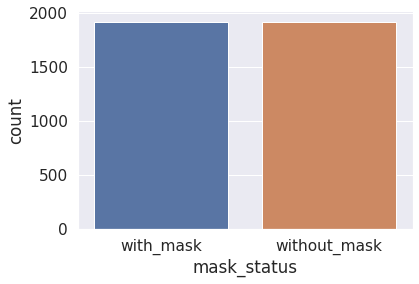

In [ ]:
mask = dataset.value_counts("mask_status")[1]
withoutmask = dataset.value_counts("mask_status")[0]

sns.countplot(dataset["mask_status"])
plt.show()

#Showing some sample images

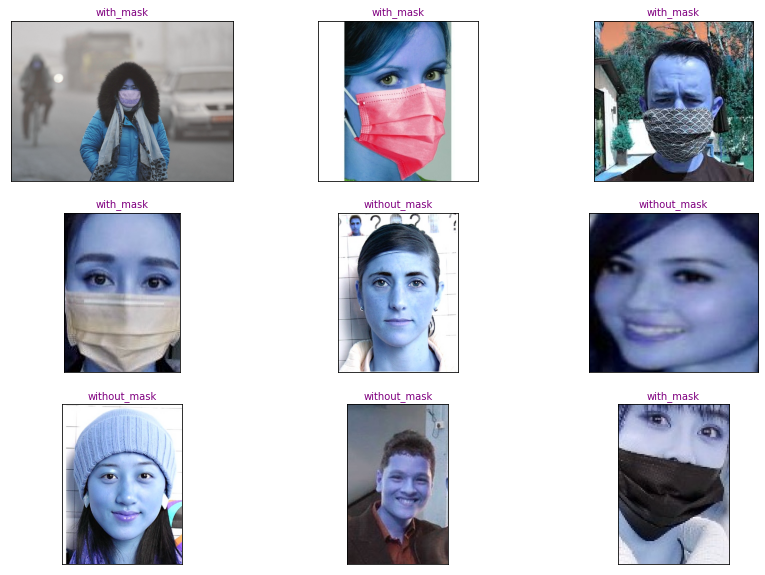

In [ ]:
plt.figure(figsize = (14,10))
for i in range(9):
    random = np.random.randint(1,len(dataset))
    plt.subplot(3,3,i+1)
    plt.imshow(cv2.imread(dataset.loc[random,"image_path"]))
    plt.title(dataset.loc[random, "mask_status"], size = 10, color = "purple") 
    plt.xticks([])
    plt.yticks([])
    
plt.show()

# perform one-hot encoding on the labels


In [ ]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels,test_size=0.20, stratify=labels, random_state=42)

#saving the data array

In [ ]:
np.save('/content/drive/MyDrive/datasets/facemaskproject/images.npy',data)
np.save('/content/drive/MyDrive/datasets/facemaskproject/labels.npy',labels)

#construct the training image generator for data augmentation



In [ ]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

# load the MobileNetV2 network model

In [ ]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

9412608/9406464 [==============================] - 0s 0us/step


In [244]:
model = Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

# compile our model

In [ ]:
print("[INFO] compiling model...")
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

[INFO] compiling model...
Epoch 1/20
95/95 [==============================] - 66s 359ms/step - loss: 0.4093 - accuracy: 0.8385 - val_loss: 0.1416 - val_accuracy: 0.9791
Epoch 2/20
95/95 [==============================] - 32s 338ms/step - loss: 0.1472 - accuracy: 0.9591 - val_loss: 0.0782 - val_accuracy: 0.9817
Epoch 3/20
95/95 [==============================] - 31s 331ms/step - loss: 0.0987 - accuracy: 0.9750 - val_loss: 0.0587 - val_accuracy: 0.9791
Epoch 4/20
95/95 [==============================] - 33s 349ms/step - loss: 0.0784 - accuracy: 0.9782 - val_loss: 0.0530 - val_accuracy: 0.9831
Epoch 5/20
95/95 [==============================] - 32s 342ms/step - loss: 0.0627 - accuracy: 0.9832 - val_loss: 0.0477 - val_accuracy: 0.9817
Epoch 6/20
95/95 [==============================] - 32s 338ms/step - loss: 0.0620 - accuracy: 0.9812 - val_loss: 0.0455 - val_accuracy: 0.9804
Epoch 7/20
95/95 [==============================] - 32s 336ms/step - loss: 0.0523 - accuracy: 0.9832 - val_loss: 0.0

In [ ]:
#saving the model history
hist_df = pd.DataFrame(H.history) 
np.save('/content/drive/MyDrive/datasets/facemaskproject/my_history.npy',H.history)
hist_df

,loss,accuracy,val_loss,val_accuracy
0,0.409298,0.838497,0.141575,0.979140
1,0.147193,0.959130,0.078153,0.981747
2,0.098687,0.974951,0.058670,0.979140
3,0.078441,0.978247,0.052977,0.983051
4,0.062729,0.983191,0.047748,0.981747
5,0.062046,0.981213,0.045476,0.980443
6,0.052349,0.983191,0.043547,0.981747
7,0.052892,0.985168,0.037047,0.985658
8,0.045016,0.986816,0.036752,0.983051
9,0.039524,0.987805,0.036892,0.984355


#Saving the model

In [ ]:
model.save("/content/drive/MyDrive/datasets/facemaskproject/maskmodel.model", save_format="h5")

In [ ]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

[INFO] evaluating network...


# show a nicely formatted classification report

In [ ]:
scrore_report = classification_report(testY.argmax(axis=1), predIdxs,target_names=lb.classes_)
print(scrore_report)

              precision    recall  f1-score   support

   with_mask       0.99      0.99      0.99       383
without_mask       0.99      0.99      0.99       384

    accuracy                           0.99       767
   macro avg       0.99      0.99      0.99       767
weighted avg       0.99      0.99      0.99       767



#Model evaluation

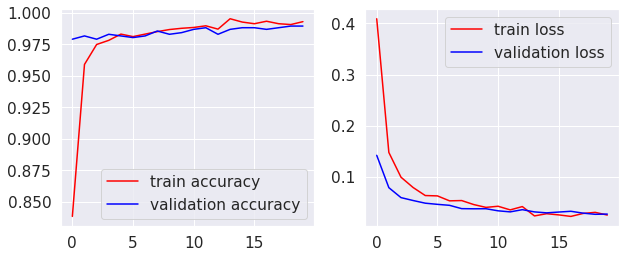

In [245]:
plt.figure(figsize = (10,4))
plt.subplot(1,2,1)
plt.plot(hist_df["accuracy"], label = "train accuracy", color = "red")
plt.plot(hist_df["val_accuracy"], label = "validation accuracy", color = "blue")
plt.legend()

plt.subplot(1,2,2)
plt.plot(hist_df["loss"], label = "train loss", color = "red")
plt.plot(hist_df["val_loss"], label = "validation loss", color = "blue")

plt.legend()
plt.show()

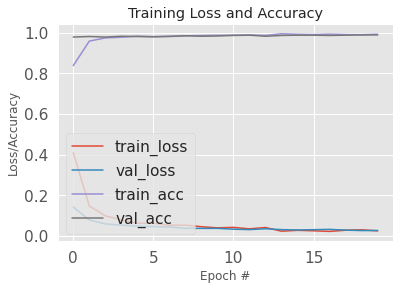

In [ ]:
# plot the training loss and accuracy
N = 20 #number of epoch
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), hist_df["loss"], label="train_loss")
plt.plot(np.arange(0, N), hist_df["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), hist_df["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), hist_df["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("/content/drive/MyDrive/datasets/facemaskproject/plot.png")
plt.show()

#Confusing matrics

In [ ]:
y_test=np.argmax(testY, axis=1)
cm = confusion_matrix(y_test, predIdxs)

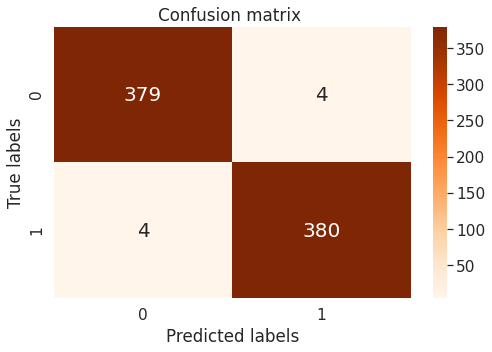

<Figure size 432x288 with 0 Axes>

In [243]:
df_cm = pd.DataFrame(cm, range(2), range(2))
plt.figure(figsize = (8,5))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, cmap='Oranges',fmt="1.0f",cbar=True,annot_kws={"size": 20}) 
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title('Confusion matrix ')
plt.show()
plt.savefig("/content/drive/MyDrive/datasets/facemaskproject/cf_matrics.png")

#checking model performance

In [ ]:
prototxtPath = r"/content/drive/MyDrive/datasets/facemaskproject/face_detector/deploy.prototxt"
weightsPath = r"/content/drive/MyDrive/datasets/facemaskproject/face_detector/res10.caffemodel"
faceNet = cv2.dnn.readNet(prototxtPath, weightsPath)
maskNet = model

In [ ]:
def detect_and_predict_mask(frame, faceNet, maskNet):
	# grab the dimensions of the frame and then construct a blob
	# from it
	(h, w) = frame.shape[:2]
	blob = cv2.dnn.blobFromImage(frame, 1.0, (224, 224),(104.0, 177.0, 123.0))

	# pass the blob through the network and obtain the face detections
	faceNet.setInput(blob)
	detections = faceNet.forward()

	faces = []
	locs = []
	preds = []

	# loop over the detections
	for i in range(0, detections.shape[2]):
		confidence = detections[0, 0, i, 2]
		if confidence > 0.5:
			box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
			(startX, startY, endX, endY) = box.astype("int")

			(startX, startY) = (max(0, startX), max(0, startY))
			(endX, endY) = (min(w - 1, endX), min(h - 1, endY))

			face = frame[startY:endY, startX:endX]
			face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
			face = cv2.resize(face, (224, 224))
			face = img_to_array(face)
			face = preprocess_input(face)
			faces.append(face)
			locs.append((startX, startY, endX, endY))
	if len(faces) > 0:
		faces = np.array(faces, dtype="float32")
		preds = maskNet.predict(faces, batch_size=32)
	return (locs, preds)

No Mask


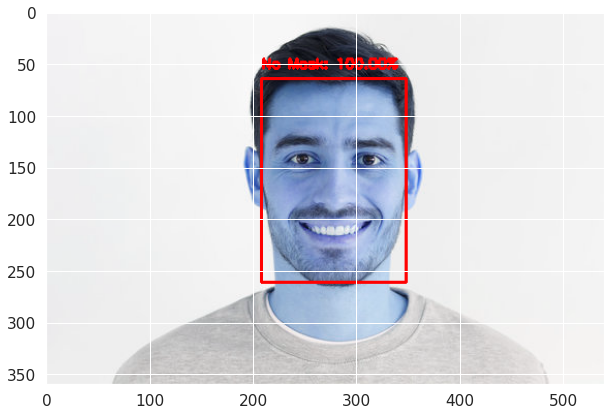

In [ ]:
frame = cv2.imread(r"/content/drive/MyDrive/datasets/facemaskproject/withoutmaskexmpl.jpg")
(locs, preds) = detect_and_predict_mask(frame, faceNet, maskNet)
# loop over the detected face locations and their corresponding
for (box, pred) in zip(locs, preds):
    # unpack the bounding box and predictions
    (startX, startY, endX, endY) = box
    (withoutMask, mask) = pred
    (startX, startY, endX, endY) = box
    (mask, withoutMask) = pred
    label = "Mask" if mask > withoutMask else "No Mask"
    color = (0, 255, 0) if label == "Mask" else (255, 0, 0)
    print(label)
    label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)
    cv2.putText(frame, label, (startX, startY - 10),cv2.FONT_ITALIC, 0.45, color, 2)
    cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)
plt.figure(figsize=(10,10))
plt.imshow(frame)

Mask


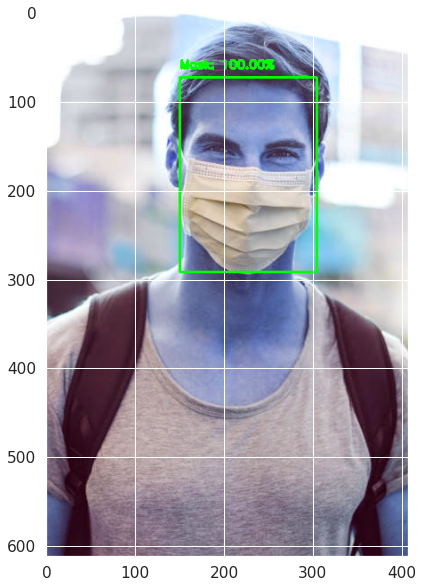

In [ ]:
frame = cv2.imread(r"/content/drive/MyDrive/datasets/facemaskproject/withMaskExmpl.jpg")
(locs, preds) = detect_and_predict_mask(frame, faceNet, maskNet)
# loop over the detected face locations and their corresponding
for (box, pred) in zip(locs, preds):
    # unpack the bounding box and predictions
    (startX, startY, endX, endY) = box
    (withoutMask, mask) = pred
    (startX, startY, endX, endY) = box
    (mask, withoutMask) = pred
    label = "Mask" if mask > withoutMask else "No Mask"
    color = (0, 255, 0) if label == "Mask" else (0, 0, 255)
    print(label)
    label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)
    cv2.putText(frame, label, (startX, startY - 10),cv2.FONT_ITALIC, 0.45, color, 2)
    cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)
plt.figure(figsize=(10,10))
plt.imshow(frame)